## Sentiment Analysis of Tweets about Trump and Clinton- Part 2  
In part 1 I did cleanup and exploratory analysis of tweets about Trump and Clinton (collected in July of 2016). Here in part 2 I'll perform sentiment analysis of the tweets.

In [1]:
%matplotlib inline 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.tools as tls
from ggplot import *

import pandas as pd
import numpy as np
import nltk
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import sys
sys.path.append('../MLRecipes')
import ml_helper as mlhelp
import pickle
import random
import warnings
warnings.filterwarnings("ignore")

/Users/jkim/anaconda/envs/py35/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
def find_features(words):
    """Takes as input a list of tokenized words and outputs features"""
    features = {}
    for w in word_features:
        features[w] = (w in words) # the dict has the word as key and boolean as value
    return features

def classify_list(classifier, token_list):
    """Get predicted label from classifier"""
    values = []
    for nested_list in token_list:
        value = classifier.classify(find_features(nested_list))
        values.append(value)
    return values

#### The data

In [3]:
originals_df = open("originals.pickle", "rb")
originals = pickle.load(originals_df)
originals_df.close()

originals.head()

,lang,text,trump,hillary,clinton,donaldtrump,hillaryclinton,bill,just_trump,just_clinton,just_hillary,Any_Clinton,Any_Clinton_no_bill,Any_Trump,tweet_tokens,just_trump_tokens,just_clinton_tokens,lower_tweet_tokens,lower_trump_tokens,lower_clinton_tokens
0,en,PROTEST WITH YOUR VOTE ITs TRUMP OR NEVER THE ...,True,False,False,False,False,False,True,False,False,False,False,True,"[PROTEST, WITH, YOUR, VOTE, ITs, TRUMP, OR, NE...","[PROTEST, WITH, YOUR, VOTE, ITs, TRUMP, OR, NE...",,"[protest, with, your, vote, its, trump, or, ne...","[protest, with, your, vote, its, trump, or, ne...",[]
1,pt,@lanadynamite ata mas trump não,True,False,False,False,False,False,True,False,False,False,False,True,"[@lanadynamite, ata, mas, trump, não]",,,"[@lanadynamite, ata, mas, trump, não]",[],[]
2,pt,Republicanos entram com pedido formal para nov...,False,True,False,False,False,False,False,False,True,True,True,False,"[Republicanos, entram, com, pedido, formal, pa...",,,"[republicanos, entram, com, pedido, formal, pa...",[],[]
3,en,@CassandraRules @Iteration23 They should be fa...,True,False,False,False,False,False,True,False,False,False,False,True,"[@CassandraRules, @Iteration23, They, should, ...","[@CassandraRules, @Iteration23, They, should, ...",,"[@cassandrarules, @iteration23, they, should, ...","[@cassandrarules, @iteration23, they, should, ...",[]
4,en,"Donald Trump bought US$120,000 trip and dinner...",True,False,False,False,False,False,True,False,False,False,False,True,"[Donald, Trump, bought, US, $, 120,000, trip, ...","[Donald, Trump, bought, US, $, 120,000, trip, ...",,"[donald, trump, bought, us, $, 120,000, trip, ...","[donald, trump, bought, us, $, 120,000, trip, ...",[]


#### Training and testing 

Note: I did not have labeled tweets for this project, but I did find a collection of short movie reviews that had been labeled as negative or positive. I will use these to train my model; this is far from perfect since tweets are probably really different from short movie reviews, but it's better than nothing. 

In [4]:
# The short positive and negative review samples
short_pos = open("short_reviews_from_pyprognet/positive.txt","r").read()
short_neg = open("short_reviews_from_pyprognet/negative.txt","r").read()

In [5]:
# Prep the reviews
documents = []

for r in short_pos.split('\n'):
    documents.append( (r, "pos") )
for r in short_neg.split('\n'):
    documents.append( (r, "neg") )

all_words = []
short_pos_words = word_tokenize(short_pos)
short_neg_words = word_tokenize(short_neg)

for w in short_pos_words:
    all_words.append(w.lower())
for w in short_neg_words:
    all_words.append(w.lower())

# This will be the words and their frequencies
all_words = nltk.FreqDist(all_words) 

# Get the first 5000 words from all_words
word_features = list(all_words.keys())[:5000]

# Save the feature existence booleans and their respective pos or neg categories. Example: (words, pos) -> ({words: True}, pos)
featuresets = [(find_features(rev), category) for (rev, category) in documents]

# Shuffle in place:
random.shuffle(featuresets)

# This data set has ~10600+ features
training_set = featuresets[:10000]
testing_set = featuresets[10000:]

#### Testing a few algorithms
Trying a few different implementations of Naive Bayes.

In [6]:
classifier = nltk.NaiveBayesClassifier.train(training_set)

MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(training_set)

BNB_classifier = SklearnClassifier(BernoulliNB())
BNB_classifier.train(training_set)

<SklearnClassifier(BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))>

I'll also try logistic regression and SVM.

In [7]:
LR_classifier = SklearnClassifier(LinearSVC())
LR_classifier.train(training_set)

SVM_classifier = SklearnClassifier(LogisticRegression())
SVM_classifier.train(training_set)

<SklearnClassifier(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))>

The accuracies were similar for the different models:

In [50]:
print("NLTK Naive Bayes algorithm accuracy percent: ", (nltk.classify.accuracy(classifier, testing_set))*100)
print("Multinomial Naive Bayes accuracy percent:",(nltk.classify.accuracy(MNB_classifier, testing_set))*100)
print("Bernoulli Naive Bayes accuracy percent:",(nltk.classify.accuracy(BNB_classifier, testing_set))*100)
print("Logistic Regression accuracy percent:",(nltk.classify.accuracy(LR_classifier, testing_set))*100)
print("SVM accuracy percent:",(nltk.classify.accuracy(SVM_classifier, testing_set))*100)

NLTK Naive Bayes algorithm accuracy percent:  67.37160120845923
Multinomial Naive Bayes accuracy percent: 68.42900302114803
Bernoulli Naive Bayes accuracy percent: 67.97583081570997
Logistic Regression accuracy percent: 65.25679758308158
SVM accuracy percent: 67.97583081570997


#### Most informative features 
A glance at which words were most informative:

In [51]:
classifier.show_most_informative_features(15)

Most Informative Features
               wonderful = True              pos : neg    =     18.0 : 1.0
                intimate = True              pos : neg    =     15.5 : 1.0
                   guise = True              neg : pos    =     12.5 : 1.0
              heartbreak = True              pos : neg    =     11.5 : 1.0
                provides = True              pos : neg    =     11.3 : 1.0
                   inept = True              neg : pos    =     11.1 : 1.0
                mindless = True              neg : pos    =     11.1 : 1.0
                   banal = True              neg : pos    =     11.1 : 1.0
                   knock = True              neg : pos    =     10.4 : 1.0
                   flaws = True              pos : neg    =      9.3 : 1.0
                  flawed = True              pos : neg    =      9.3 : 1.0
              meandering = True              neg : pos    =      9.1 : 1.0
                 iranian = True              pos : neg    =      8.9 : 1.0

#### Classify tweets

In [65]:
# Prep the list of tokens
trump_tokens_list = originals['lower_trump_tokens'].tolist()
clinton_tokens_list = originals['lower_clinton_tokens'].tolist()

# Getting rid of empty lists
trump_list = [x for x in trump_tokens_list if x !=[]]
clinton_list = [x for x in clinton_tokens_list if x !=[]]

# I'm just going to classify 500 tweets for each candidate 
# mostly because I don't want to wait forever
trump = trump_list[0:500]
clinton = clinton_list[0:500]

In [66]:
MNB_trump_vals = classify_list(MNB_classifier, trump)
MNB_clinton_vals = classify_list(MNB_classifier, clinton)

BNB_trump_vals = classify_list(BNB_classifier, trump)
BNB_clinton_vals = classify_list(BNB_classifier, clinton)

LR_trump_vals = classify_list(LR_classifier, trump)
LR_clinton_vals = classify_list(LR_classifier, clinton)

SVM_trump_vals = classify_list(SVM_classifier, trump)
SVM_clinton_vals = classify_list(SVM_classifier, clinton)

In [72]:
all_trump_pos = pd.Series((MNB_trump_vals.count('pos'), BNB_trump_vals.count('pos'),
                            LR_trump_vals.count('pos'), SVM_trump_vals.count('pos')))

all_trump_neg = pd.Series((MNB_trump_vals.count('neg'), BNB_trump_vals.count('neg'),
                            LR_trump_vals.count('neg'), SVM_trump_vals.count('neg')))

all_clinton_pos = pd.Series((MNB_clinton_vals.count('pos'), BNB_clinton_vals.count('pos'),
                            LR_clinton_vals.count('pos'), SVM_clinton_vals.count('pos')))

all_clinton_neg = pd.Series((MNB_clinton_vals.count('neg'), BNB_clinton_vals.count('neg'),
                            LR_clinton_vals.count('neg'), SVM_clinton_vals.count('neg')))

#### Tweets about Trump

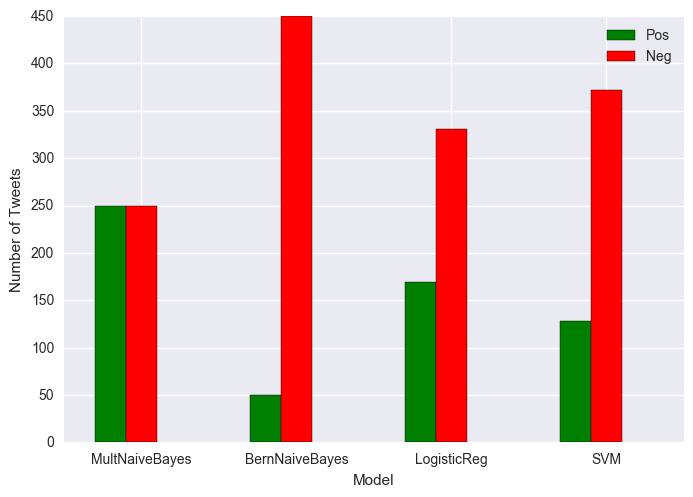

In [73]:
multiple_bars=plt.figure()
x=['MultNaiveBayes', 'BernNaiveBayes', 'LogisticReg', 'SVM']
ind=np.arange(len(x))
pos = all_trump_pos
neg = all_trump_neg

ax.set_title("Trump's Positive and Negative Tweets")
ax=plt.subplot(111)
ax.bar(ind-.2, pos, width=.2, color='g', align='center', label='Pos')
ax.bar(ind, neg, width=.2, color='r', align='center', label='Neg')

ax.set_xticks(ind)
ax.set_xticklabels(x)
ax.set_ylabel('Number of Tweets')
ax.set_xlabel('Model')
ax.legend(loc='best')

In [86]:
print("Percent negative MNB classifier:",(MNB_trump_vals.count('neg')/len(MNB_trump_vals)*100))
print("Percent negative BNB classifier:",(BNB_trump_vals.count('neg')/len(BNB_trump_vals)*100))
print("Percent negative LR classifier:",(LR_trump_vals.count('neg')/len(LR_trump_vals)*100))
print("Percent negative SVM classifier:",(SVM_trump_vals.count('neg')/len(SVM_trump_vals)*100))

Percent negative MNB classifier: 50.0
Percent negative BNB classifier: 90.0
Percent negative LR classifier: 66.2
Percent negative SVM classifier: 74.4


#### Tweets about Clinton

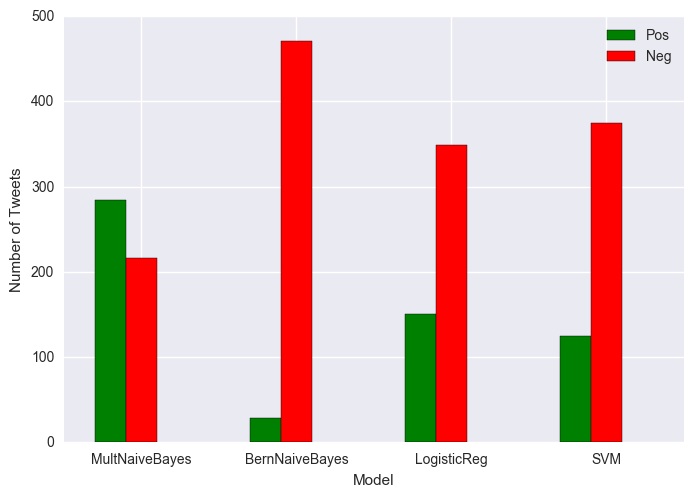

In [74]:
multiple_bars=plt.figure()
x=['MultNaiveBayes', 'BernNaiveBayes', 'LogisticReg', 'SVM']
ind=np.arange(len(x))
pos = all_clinton_pos
neg = all_clinton_neg

ax.set_title("Clinton's Positive and Negative Tweets")
ax=plt.subplot(111)
ax.bar(ind-.2, pos, width=.2, color='g', align='center', label='Pos')
ax.bar(ind, neg, width=.2, color='r', align='center', label='Neg')

ax.set_xticks(ind)
ax.set_xticklabels(x)
ax.set_ylabel('Number of Tweets')
ax.set_xlabel('Model')
ax.legend(loc='best')

In [88]:
print("Percent negative MNB classifier:",(MNB_clinton_vals.count('neg')/len(MNB_clinton_vals)*100))
print("Percent negative BNB classifier:",(BNB_clinton_vals.count('neg')/len(BNB_clinton_vals)*100))
print("Percent negative LR classifier:",(LR_clinton_vals.count('neg')/len(LR_clinton_vals)*100))
print("Percent negative SVM classifier:",(SVM_clinton_vals.count('neg')/len(SVM_clinton_vals)*100))

Percent negative MNB classifier: 43.2
Percent negative BNB classifier: 94.19999999999999
Percent negative LR classifier: 69.8
Percent negative SVM classifier: 75.0


The tweets were overwhelmingly classified as negative for both candidates. Of course these classifiers are not great for tweets, because they were trained on short movie reviews. In particular I'm guessing that movie reviews don't use as many acronyms as tweets. And I can also imagine that they're generally less sarcastic than tweets.

If I were to try to improve on the classifier I'd get some tweets labeled, and also include more classes so that in addition to "positive" and "negative" I'd have "neutral" and maybe also "sarcastic." I'd also explore whether emoticons were predictive of sentiment.